## Terrain Classification using DeepViT

In [1]:
import re
import os
import sys
import json
import cv2
import timm
import torch
import random
import safetensors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from functools import partial
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms


from rich import print
from num2words import num2words

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import (
    Dataset,
    create_loader,
    resolve_data_config,
    Mixup,
    FastCollateMixup,
    ImageFolderLMDB,
)
from timm.models import (
    create_model,
    resume_checkpoint,
    load_checkpoint,
    convert_splitbn_model,
)

from timm.utils import *
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.loss import (
    LabelSmoothingCrossEntropy,
    SoftTargetCrossEntropy,
    JsdCrossEntropy,
)
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler
from timm.utils import ApexScaler, NativeScaler
from timm.models.registry import register_model
from utils.flops_counter import get_model_complexity_info

try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as ApexDDP
    from apex.parallel import convert_syncbn_model

    has_apex = True
except ImportError:
    has_apex = False

### Load and prepare the dataset 

The created class indices are: 

{'Coast': 0, 'Desert': 1, 'Forest': 2, 'Glacier': 3, 'Mountain': 4}

Training Images:

Mountain               : 100%|████████████████████████████████████████| 2000/2000 [00:00<00:00, 3707.11file/s]


Validation Images:

Mountain               : 100%|██████████████████████████████████████████| 300/300 [00:00<00:00, 3827.84file/s]


5 kind of training images were found in the dataset

5 kind of validation images were found in the dataset

training_filepaths labels_train
6600  ../../Dataset/Landscape Classification/train/G...      Glacier
8114  ../../Dataset/Landscape Classification/train/M...     Mountain
4215  ../../Dataset/Landscape Classification/train/F...       Forest
2459  ../../Dataset/Landscape Classification/train/D...       Desert
1089  ../../Dataset/Landscape Classification/train/C...        Coast
6406  ../../Dataset/Landscape Classification/train/G...      Glacier
8527  ../../Dataset/Landscape Classification/train/M...     Mountain
3619  ../../Dataset/Landscape Classification/train/D...       Desert
4477  ../../Dataset/Landscape Classification/train/F...       Forest
1568  ../../Dataset/Landscape Classification/train/C...        Coast
2157  ../../Dataset/Landscape Classification/train/D...       Desert
9958  ../../Dataset/Landscape Classification/train/M...     Mountain
1463  ../../Dataset/Landscape Classification/train/C...        Coast
3218  ../../Dataset/Landscape Classification/train/D...       Desert
6876  ../../Dataset/Landscape Classification/train/G...      Glacier
7226  ../../Dataset/Landscape Classification/train/G...      Glacier
130   ../../Dataset/Landscape Classification/train/C...        Coast
6270  ../../Dataset/Landscape Classification/train/G...      Glacier
1364  ../../Dataset/Landscape Classification/train/C...        Coast
8098  ../../Dataset/Landscape Classification/train/M...     Mountain
196   ../../Dataset/Landscape Classification/train/C...        Coast
8007  ../../Dataset/Landscape Classification/train/M...     Mountain
4231  ../../Dataset/Landscape Classification/train/F...       Forest
4149  ../../Dataset/Landscape Classification/train/F...       Forest
525   ../../Dataset/Landscape Classification/train/C...        Coast
399   ../../Dataset/Landscape Classification/train/C...        Coast
9479  ../../Dataset/Landscape Classification/train/M...     Mountain
2225  ../../Dataset/Landscape Classification/train/D...       Desert
5775  ../../Dataset/Landscape Classification/train/F...       Forest
634   ../../Dataset/Landscape Classification/train/C...        Coast
4262  ../../Dataset/Landscape Classification/train/F...       Forest
4554  ../../Dataset/Landscape Classification/train/F...       Forest
8296  ../../Dataset/Landscape Classification/train/M...     Mountain
1784  ../../Dataset/Landscape Classification/train/C...        Coast
1486  ../../Dataset/Landscape Classification/train/C...        Coast
1194  ../../Dataset/Landscape Classification/train/C...        Coast
8680  ../../Dataset/Landscape Classification/train/M...     Mountain
3520  ../../Dataset/Landscape Classification/train/D...       Desert
1117  ../../Dataset/Landscape Classification/train/C...        Coast
5830  ../../Dataset/Landscape Classification/train/F...       Forest
2556  ../../Dataset/Landscape Classification/train/D...       Desert
1656  ../../Dataset/Landscape Classification/train/C...        Coast
7952  ../../Dataset/Landscape Classification/train/G...      Glacier
4602  ../../Dataset/Landscape Classification/train/F...       Forest
7596  ../../Dataset/Landscape Classification/train/G...      Glacier
7135  ../../Dataset/Landscape Classification/train/G...      Glacier
762   ../../Dataset/Landscape Classification/train/C...        Coast
2799  ../../Dataset/Landscape Classification/train/D...       Desert
9408  ../../Dataset/Landscape Classification/train/M...     Mountain
4266  ../../Dataset/Landscape Classification/train/F...       Forest

validation_filepaths labels_validation
131   ../../Dataset/Landscape Classification/val/Coa...             Coast
1028  ../../Dataset/Landscape Classification/val/Gla...           Glacier
620   ../../Dataset/Landscape Classification/val/For...            Forest
962   ../../Dataset/Landscape Classification/val/Gla...           Glacier
660   ../../Dataset/Landscape Classification/val/For...            Forest
174   ../../Dataset/Landscape Classification/val/Coa...             Coast
160   ../../Dataset/Landscape Classification/val/Coa...             Coast
519   ../../Dataset/Landscape Classification/val/Des...            Desert
772   ../../Dataset/Landscape Classification/val/For...            Forest
95    ../../Dataset/Landscape Classification/val/Coa...             Coast
233   ../../Dataset/Landscape Classification/val/Coa...             Coast
799   ../../Dataset/Landscape Classification/val/For...            Forest
85    ../../Dataset/Landscape Classification/val/Coa...             Coast
652   ../../Dataset/Landscape Classification/val/For...            Forest
1324  ../../Dataset/Landscape Classification/val/Mou...          Mountain
622   ../../Dataset/Landscape Classification/val/For...            Forest
606   ../../Dataset/Landscape Classification/val/For...            Forest
137   ../../Dataset/Landscape Classification/val/Coa...             Coast
1391  ../../Dataset/Landscape Classification/val/Mou...          Mountain
55    ../../Dataset/Landscape Classification/val/Coa...             Coast
808   ../../Dataset/Landscape Classification/val/For...            Forest
839   ../../Dataset/Landscape Classification/val/For...            Forest
754   ../../Dataset/Landscape Classification/val/For...            Forest
1475  ../../Dataset/Landscape Classification/val/Mou...          Mountain
1217  ../../Dataset/Landscape Classification/val/Mou...          Mountain
805   ../../Dataset/Landscape Classification/val/For...            Forest
290   ../../Dataset/Landscape Classification/val/Coa...             Coast
594   ../../Dataset/Landscape Classification/val/Des...            Desert
1447  ../../Dataset/Landscape Classification/val/Mou...          Mountain
787   ../../Dataset/Landscape Classification/val/For...            Forest
226   ../../Dataset/Landscape Classification/val/Coa...             Coast
399   ../../Dataset/Landscape Classification/val/Des...            Desert
1453  ../../Dataset/Landscape Classification/val/Mou...          Mountain
1020  ../../Dataset/Landscape Classification/val/Gla...           Glacier
1010  ../../Dataset/Landscape Classification/val/Gla...           Glacier
1031  ../../Dataset/Landscape Classification/val/Gla...           Glacier
601   ../../Dataset/Landscape Classification/val/For...            Forest
201   ../../Dataset/Landscape Classification/val/Coa...             Coast
502   ../../Dataset/Landscape Classification/val/Des...            Desert
1312  ../../Dataset/Landscape Classification/val/Mou...          Mountain
455   ../../Dataset/Landscape Classification/val/Des...            Desert
47    ../../Dataset/Landscape Classification/val/Coa...             Coast
788   ../../Dataset/Landscape Classification/val/For...            Forest
1250  ../../Dataset/Landscape Classification/val/Mou...          Mountain
1208  ../../Dataset/Landscape Classification/val/Mou...          Mountain
102   ../../Dataset/Landscape Classification/val/Coa...             Coast
1198  ../../Dataset/Landscape Classification/val/Gla...           Glacier
820   ../../Dataset/Landscape Classification/val/For...            Forest
441   ../../Dataset/Landscape Classification/val/Des...            Desert
497   ../../Dataset/Landscape Classification/val/Des...            Desert

average image height=  189   average image width=  269  aspect ratio h/w=  0.7026022304832714

10000 images were found in the dataset.
10000 for training, 1500 for validation

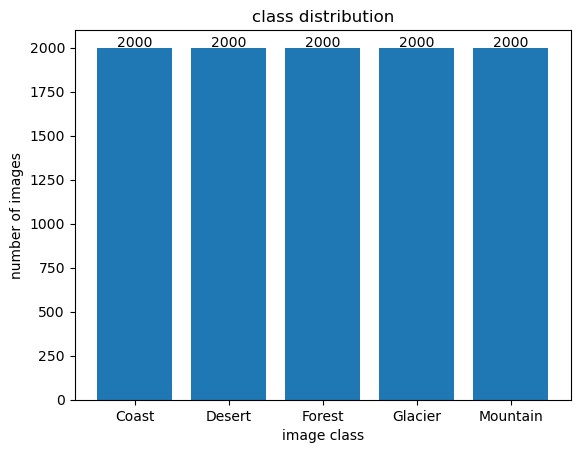

In [9]:
# Prepare the dataset

root = "../../Dataset/Landscape Classification/"
training_path = root + "train"
validation_path = root + "val"


def read_split_data(root, plot_image=False):
    filepaths_train = []
    labels_train = []

    filepaths_validation = []
    labels_validation = []

    bad_images_train = []
    bad_images_validation = []

    random.seed(0)

    assert os.path.exists(root), "The specified root path doesn't exist"

    classes_train = [
        c
        for c in os.listdir(training_path)
        if os.path.isdir(os.path.join(training_path, c))
    ]
    classes_train.sort()

    class_indices = {k: v for v, k in enumerate(classes_train)}

    print("The created class indices are: \n", class_indices)

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open("class_indices.json", "w") as json_file:
        json_file.write(json_str)

    every_class_num = []
    every_class_num_val = []

    supported = [".jpg", ".png", ".jpeg", ".PNG", ".JPG", ".JPEG"]

    print("Training Images:")
    for c in classes_train:
        # Gather Training Images
        classpath_train = os.path.join(training_path, c)

        if not os.path.exists(classpath_train):
            print(f"{classpath_train} doesn't exist")

        images_train = [
            os.path.join(training_path, c, i)
            for i in os.listdir(classpath_train)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num.append(len(images_train))
        file_list_train = sorted(os.listdir(classpath_train))

        desc = f"{c:23}"

        for f in tqdm(
            file_list_train, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_train, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_train.append(fpath)
                    labels_train.append(c)
                except:
                    bad_images_train.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_train.append(fpath)

    validation = [
        v
        for v in os.listdir(validation_path)
        if os.path.isdir(os.path.join(validation_path, v))
    ]
    validation.sort()

    validation_indices = {k: v for v, k in enumerate(validation)}

    print("Validation Images: ")

    for v in validation:
        # Gather Training Images
        classpath_validation = os.path.join(validation_path, v)
        images_validation = [
            os.path.join(validation_path, v, i)
            for i in os.listdir(classpath_validation)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num_val.append(len(images_validation))
        file_list_validation = sorted(os.listdir(classpath_validation))

        desc = f"{v:23}"

        for f in tqdm(
            file_list_validation, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_validation, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_validation.append(fpath)
                    labels_validation.append(v)
                except:
                    bad_images_validation.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_validation.append(fpath)

    train_filepath_series = pd.Series(filepaths_train, name="training_filepaths")
    validation_filepath_series = pd.Series(
        filepaths_validation, name="validation_filepaths"
    )

    train_label_series = pd.Series(labels_train, name="labels_train")
    validation_label_series = pd.Series(labels_validation, name="labels_validation")

    df_train = pd.concat([train_filepath_series, train_label_series], axis=1)

    print(
        f"{len(df_train.labels_train.unique())} kind of training images were found in the dataset"
    )

    df_validation = pd.concat(
        [validation_filepath_series, validation_label_series], axis=1
    )
    print(
        f"{len(df_validation.labels_validation.unique())} kind of validation images were found in the dataset"
    )
    # dump the filepaths and labels for training and validation
    df_train.to_csv("train_dump.csv")
    df_validation.to_csv("validation_dump.csv")

    image_label_train = [class_indices[i] for i in df_train["labels_train"].tolist()]
    image_label_val = [
        class_indices[i] for i in df_validation["labels_validation"].tolist()
    ]

    sample_df_train = df_train.sample(n=50, replace=False)
    sample_df_validation = df_validation.sample(n=50, replace=False)

    print(sample_df_train)
    print(sample_df_validation)

    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df_train)):
        fpath = sample_df_train["training_filepaths"].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave

    print(
        "average image height= ",
        have,
        "  average image width= ",
        wave,
        " aspect ratio h/w= ",
        aspect_ratio,
    )

    print(
        "{} images were found in the dataset.\n{} for training, {} for validation".format(
            sum(every_class_num), len(filepaths_train), len(filepaths_validation)
        )
    )
    if plot_image:
        print("Training Image")
        plt.bar(range(len(classes_train)), every_class_num, align="center")
        plt.xticks(range(len(classes_train)), classes_train)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha="center")

        plt.xlabel("image class")
        plt.ylabel("number of images")

        plt.title("class distribution for training images")
        plt.show()

    return (
        filepaths_train,
        filepaths_validation,
        image_label_train,
        image_label_val,
        class_indices,
    )


filepath_list_tr, filepath_list_val, label_tr, label_val, cls_indices = read_split_data(
    root=root
)

with open("fpath_tr.txt", "a") as f:
    for i in filepath_list_tr:
        f.write(i)

## Add the DeepViT Code from the repo
code taken from: 

In [ ]:
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
        expansion_ratio=3,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
        expansion_ratio=3,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.expansion = expansion_ratio
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * self.expansion, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, atten=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class ReAttention(nn.Module):
    """
    It is observed that similarity along same batch of data is extremely large.
    Thus can reduce the bs dimension when calculating the attention map.
    """

    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
        expansion_ratio=3,
        apply_transform=True,
        transform_scale=False,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.apply_transform = apply_transform

        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim**-0.5
        if apply_transform:
            self.reatten_matrix = nn.Conv2d(self.num_heads, self.num_heads, 1, 1)
            self.var_norm = nn.BatchNorm2d(self.num_heads)
            self.qkv = nn.Linear(dim, dim * expansion_ratio, bias=qkv_bias)
            self.reatten_scale = self.scale if transform_scale else 1.0
        else:
            self.qkv = nn.Linear(dim, dim * expansion_ratio, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, atten=None):
        B, N, C = x.shape
        # x = self.fc(x)
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        if self.apply_transform:
            attn = self.var_norm(self.reatten_matrix(attn)) * self.reatten_scale
        attn_next = attn
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_next


class Block(nn.Module):

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        expansion=3,
        group=False,
        share=False,
        re_atten=False,
        bs=False,
        apply_transform=False,
        scale_adjustment=1.0,
        transform_scale=False,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.re_atten = re_atten

        self.adjust_ratio = scale_adjustment
        self.dim = dim
        if self.re_atten:
            self.attn = ReAttention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                expansion_ratio=expansion,
                apply_transform=apply_transform,
                transform_scale=transform_scale,
            )
        else:
            self.attn = Attention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                expansion_ratio=expansion,
            )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, atten=None):
        if self.re_atten:
            x_new, atten = self.attn(self.norm1(x * self.adjust_ratio), atten)
            x = x + self.drop_path(x_new / self.adjust_ratio)
            x = (
                x
                + self.drop_path(self.mlp(self.norm2(x * self.adjust_ratio)))
                / self.adjust_ratio
            )
            return x, atten
        else:
            x_new, atten = self.attn(self.norm1(x), atten)
            x = x + self.drop_path(x_new)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x, atten


class PatchEmbed_CNN(nn.Module):
    """
    Following T2T, we use 3 layers of CNN for comparison with other methods.
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, spp=32):
        super().__init__()

        new_patch_size = to_2tuple(patch_size // 2)

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.conv1 = nn.Conv2d(
            in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False
        )  # 112x112
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            64, 64, kernel_size=3, stride=1, padding=1, bias=False
        )  # 112x112
        self.bn2 = nn.BatchNorm2d(64)

        self.proj = nn.Conv2d(
            64, embed_dim, kernel_size=new_patch_size, stride=new_patch_size
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.proj(x).flatten(2).transpose(1, 2)  # [B, C, W, H]

        return x


class PatchEmbed(nn.Module):
    """
    Same embedding as timm lib.
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class HybridEmbed(nn.Module):
    """
    Same embedding as timm lib.
    """

    def __init__(
        self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768
    ):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[
                    -1
                ]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class DeepVisionTransformer(nn.Module):
    """Vision Transformer with support for patch or hybrid CNN input stage"""

    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        hybrid_backbone=None,
        norm_layer=nn.LayerNorm,
        group=False,
        re_atten=True,
        cos_reg=False,
        use_cnn_embed=False,
        apply_transform=None,
        transform_scale=False,
        scale_adjustment=1.0,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = (
            embed_dim  # num_features for consistency with other models
        )
        # use cosine similarity as a regularization term
        self.cos_reg = cos_reg

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone,
                img_size=img_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
            )
        else:
            if use_cnn_embed:
                self.patch_embed = PatchEmbed_CNN(
                    img_size=img_size,
                    patch_size=patch_size,
                    in_chans=in_chans,
                    embed_dim=embed_dim,
                )
            else:
                self.patch_embed = PatchEmbed(
                    img_size=img_size,
                    patch_size=patch_size,
                    in_chans=in_chans,
                    embed_dim=embed_dim,
                )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        d = depth if isinstance(depth, int) else len(depth)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, d)
        ]  # stochastic depth decay rule

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    share=depth[i],
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                    group=group,
                    re_atten=re_atten,
                    apply_transform=apply_transform[i],
                    transform_scale=transform_scale,
                    scale_adjustment=scale_adjustment,
                )
                for i in range(len(depth))
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = (
            nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token"}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=""):
        self.num_classes = num_classes
        self.head = (
            nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        if self.cos_reg:
            atten_list = []
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(
            B, -1, -1
        )  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        attn = None
        for blk in self.blocks:
            x, attn = blk(x, attn)
            if self.cos_reg:
                atten_list.append(attn)

        x = self.norm(x)
        if self.cos_reg and self.training:
            return x[:, 0], atten_list
        else:
            return x[:, 0]

    def forward(self, x):
        if self.cos_reg and self.training:
            x, atten = self.forward_features(x)
            x = self.head(x)
            return x, atten
        else:
            x = self.forward_features(x)
            x = self.head(x)
            return x

In [ ]:
# Initialize the model


def _cfg(url="", **kwargs):
    return {
        "url": url,
        "num_classes": 1000,
        "input_size": (3, 224, 224),
        "pool_size": None,
        "crop_pct": 0.9,
        "interpolation": "bicubic",
        "mean": IMAGENET_DEFAULT_MEAN,
        "std": IMAGENET_DEFAULT_STD,
        "first_conv": "patch_embed.proj",
        "classifier": "head",
        **kwargs,
    }


default_cfgs = {
    # patch models
    "Deepvit_base_patch16_224_16B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_base_patch16_224_24B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_base_patch16_224_32B": _cfg(
        url="",
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
    "Deepvit_L_384": _cfg(
        url="",
        input_size=(3, 384, 384),
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
        crop_pct=1.0,
    ),
}

apply_transform = [False] * 0 + [True] * 16


@register_model
def TerrainDeepViT_S(pretrained=False, **kwargs) -> DeepVisionTransformer:

    model = DeepVisionTransformer(
        patch_size=16,
        embed_dim=384,
        depth=[False] * 16,
        num_classes=5,
        apply_transform=apply_transform,
        num_heads=12,
        mlp_ratio=3,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        transform_scale=True,
        scale_adjustment=0.5,
    )

    # We following the same settings for original ViT
    model.default_cfg = default_cfgs["Deepvit_base_patch16_224_32B"]

    # calculate the total number
    total_parameters_DViT_S = sum(p.numel() for p in model.parameters())

    print("[#06ffff]Loading TerrainViT_S...")
    print(
        f"[#06ffff]Total number of parameter for TerrainDViT_S is[#06ffff] [bold #04ff00]{num2words(total_parameters_DViT_S)}[/bold #04ff00]"
    )

    return model

### Model and training Config

In [ ]:
# Yaml config file
config_path = "./TerrainDeepViT_S.yaml"

# Model Config
num_classes = 5
bn_tf = False  # BatchNorm
bn_eps = None  # BatchNorm epsilon override
bn_momentum = None  # BatchNorm momentum Override
checkpoint_path = ""  # Initial checkpoint to start training from
cos_reg = 0
device = "cuda"
drop_rate = 0.0
drop_block = None
drop_connect = None
drop_path_rate = 0.2
global_pool = None
pretrained = False
torchscript = False
use_cos_reg = cos_reg > 0

# training config
auto_augmentation = "rand-m9-mstd0.5-inc1"  # use random augmentation
batch_size = 128
clip_grad = None  # clip the gradients
color_jitter = 0.4
dataset_path = "../../Dataset/Landscape Classification/"
decay_epochs = 30
decay_rate = 0.1
input_size = (
    3,
    224,
    224,
)  # resolve_data_config(vars(args), model=model, verbose=args.local_rank == 0)
min_lr = 1.0e-05
mixup = 0.8
mixup_mode = "batch"
mixup_off_epoch = 0
mixup_prob = 1.0
mixup_switch_prob = 0.5
model_ema = True
model_ema_decay = 0.99996
model_ema_force_cpu = False
momentum = 0.9
no_augmentation = False
num_aug_splits = 0
output = "output/TerrainDeepViT_S"
ratio = [0.75, 1.3333333333333333]  # Random aspect ratio
re_mode = "pixel"  # Random erase
reprob = 0.25
resplit = False
hflip = 0.5  # horizontal flip probability
vflip = 0.0  # vertical flip probability
lr = 0.001  # Learning rate
lr_cycle_limit = 1
lr_cycle_mul = 1.0
lr_noise = None
lr_noise_pct = 0.67
lr_noise_std = 1.0
optimizer = "adamw"
scheduler = "cosine"
warmup_epochs = 5
warmup_lr = 1.0e-06
weight_decay = 0.05
workers = 8
# use_amp = "apex"

In [ ]:
# Create the model and train using timm

model = timm.create_model(
    "TerrainDeepViT_S",
    pretrained=False,
    checkpoint_path=checkpoint_path,
    num_classes=num_classes,
    bn_tf=bn_tf,
    bn_momentum=bn_momentum,
    bn_eps=bn_eps,
    drop_block=drop_block,
    drop_connect=drop_connect,
    drop_path_rate=drop_path_rate,
    drop_rate=drop_rate,
    global_pool=global_pool,
    use_cos_reg=use_cos_reg,
    scriptable=torchscript,
)

if num_aug_splits > 0:
    assert num_aug_splits > 1, "An aug_split of 1 doesn't make sense"

Loading TerrainViT_S...

Total number of parameter for TerrainDViT_S is twenty-four million, forty-three thousand, five hundred and 
eighty-nine

In [ ]:
%run train.py --config ./TerrainDeepViT_S.yaml "../../Dataset/Landscape Classification/"

Training with a single process on 1 GPUs.


Loading TerrainViT_S...

Total number of parameter for TerrainDViT_S is twenty-four million, forty-three thousand, five hundred and 
eighty-nine

Model TerrainDeepViT_S created, param count: 24043589
Data processing configuration for current model + dataset:
	input_size: (3, 224, 224)
	interpolation: bicubic
	mean: (0.5, 0.5, 0.5)
	std: (0.5, 0.5, 0.5)
	crop_pct: 0.9
AMP not enabled. Training in float32.
Restoring model state from checkpoint...
Restoring optimizer state from checkpoint...
Loaded checkpoint '/home/mohanakrishna/Development/GSSoC/output/terraindeepvit_S/train/20240615-025115-TerrainDeepViT_S-224/last.pth.tar' (epoch 276)
Scheduled epochs: 310
creating ../output/terraindeepvit_S/train/20240618-173244-TerrainDeepViT_S-224/code/deep_vit
copying /home/mohanakrishna/Development/GSSoC/terrain classification/Model/TerrainDeepViT/deep_vit/LICENSE -> ../output/terraindeepvit_S/train/20240618-173244-TerrainDeepViT_S-224/code/deep_vit
copying /home/mohanakrishna/Development/GSSoC/terrain classification/Model/TerrainDeepViT/deep_vit/clean_checkpoint.py -> ../output/terraindeepvit_S/train/20240618-173244-TerrainDeepViT_S-224/c

### Inference and evaluation

Loading TerrainViT_S...

Total number of parameter for TerrainDViT_S is twenty-four million, forty-three thousand, five hundred and 
eighty-nine

Model DeepVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-15): 16 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): ReAttention(
        (reatten_matrix): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
        (var_norm): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1152, bias=True)
        (fc2): Linear(in_features=1152, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=384, out_features=5, bias=True)
) created, param count: 24043589

there were 112 errors in 500 tests for an accuracy of  77.60%

The F1-score was 77.193

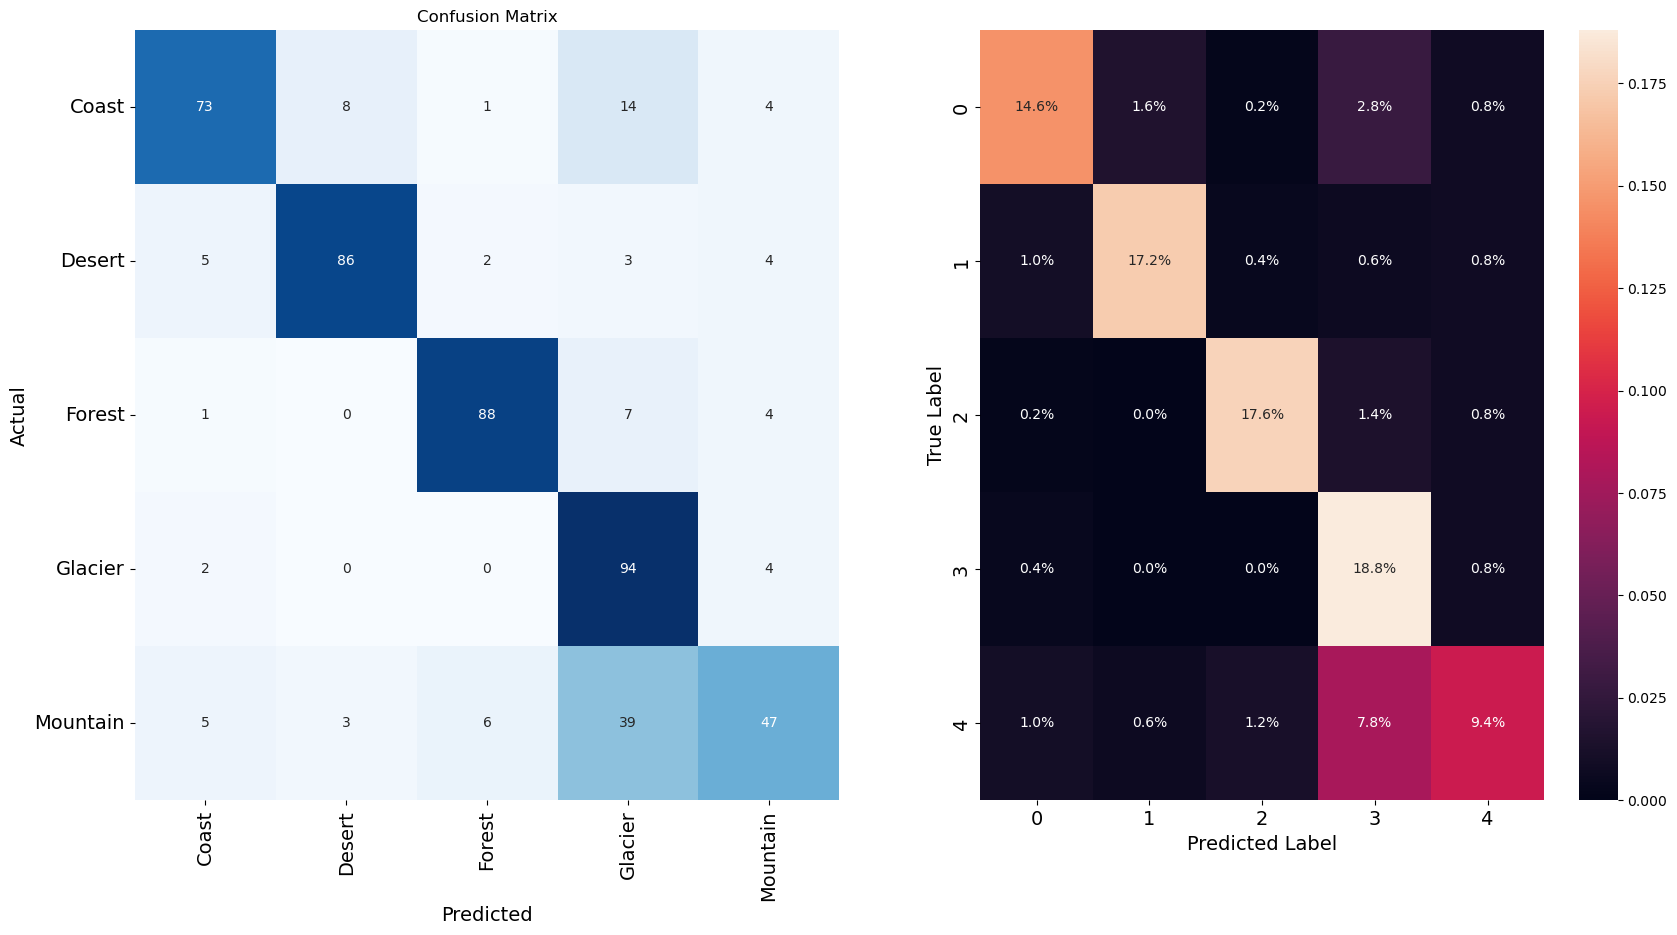

Classification Report:
----------------------
               precision    recall  f1-score   support

       Coast     0.8488    0.7300    0.7849       100
      Desert     0.8866    0.8600    0.8731       100
      Forest     0.9072    0.8800    0.8934       100
     Glacier     0.5987    0.9400    0.7315       100
    Mountain     0.7460    0.4700    0.5767       100

    accuracy                         0.7760       500
   macro avg     0.7975    0.7760    0.7719       500
weighted avg     0.7975    0.7760    0.7719       500

In [ ]:
model_path = "../output/terraindeepvit_S_ft/train/20240618-191806-TerrainDeepViT_S-224/checkpoint-10.pth.tar"
test_data_path = "../../Dataset/Testing Data/"

# 224,193, 203

model = create_model(
    model_name="TerrainDeepViT_S",
    pretrained=True,
    num_classes=5,
    in_channels=3,
    global_pool=global_pool,
    scriptable=torchscript,
    amp=False,
)

model = model.cuda()

load_checkpoint(
    model=model,
    checkpoint_path=model_path,
    use_ema=False,
)

print(
    "Model %s created, param count: %d"
    % (model, sum([m.numel() for m in model.parameters()]))
)

loader = create_loader(
    Dataset(test_data_path),
    input_size=input_size,
    batch_size=batch_size,
    use_prefetcher=True,
    interpolation="bicubic",
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    num_workers=8,
    crop_pct=0.9,
)


try:
    json_file = open("./class_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # print(f"images:{images}, labels:{labels}, datatype: {images.dtype}")
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(loader)

### Save the checkpoint

In [ ]:
import safetensors.torch

# Save the model in default pytorch format (timm uses an entirely different format .pth.tar
# which stores epochs and other info along with ema weights)

torch.save(model, "TerrainDeepViT_S-203-epoch-77.40-acc.pt")

# Add safetensors variant as well
safetensors.torch.save_model(model, "TerrainDeepViT_S-203-epoch-77.40-acc.safetensors")

In [ ]:
# verfiy safe_open

tensors = {}

with safetensors.safe_open(
    filename="./TerrainDeepViT_S-203-epoch-77.40-acc.safetensors",
    framework="pt",
    device=device,
) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

print(len(tensors))

312

### Creating the inference code

In [ ]:
# Loading from safetensors
inference_model = TerrainDeepViT_S(in_channels=3)
inference_model.load_state_dict(tensors)
inference_model.to(device)

inference_model.eval()

class_indices = json.load(open("./class_indices.json", "r"))

image_path = "../../Images/image.png"
image = Image.open(
    fp=image_path,
)

transform_compose = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(std=IMAGENET_DEFAULT_STD, mean=IMAGENET_DEFAULT_MEAN),
    ]
)

image_tensor = transform_compose(image)
image_tensor = image_tensor.unsqueeze(0).to(device)

print(image_tensor.shape)

with torch.no_grad():
    prediction = torch.argmax(inference_model(image_tensor).to("cpu"), dim=1)

print(
    f"predicted class for the given image is a {class_indices[str(prediction.item())]}"
)

Loading TerrainViT_S...

Total number of parameter for TerrainDViT_S is twenty-four million, forty-three thousand, five hundred and 
eighty-nine

torch.Size([1, 3, 224, 224])

predicted class for the given image is: Mountain